In [124]:
# importi posebej, ker kdaj pozabi kaj je bilo importano?
import pandas as pd
import numpy as np
import isodate
import json
import datetime
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [111]:
# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.options.display.max_rows = 10

# izberemo interaktivni "notebook" stil risanja
%matplotlib notebook
# naložimo razpredelnico, s katero bomo delali
ar_ingredients = pd.read_csv('data/ar_ingredients.csv')
ar_recipes = pd.read_csv('data/ar_recipes.csv', index_col='id')
ar_steps = pd.read_csv('data/ar_steps.csv')
jo_ingredients = pd.read_csv('data/jo_ingredients.csv')
jo_recipes = pd.read_csv('data/jo_recipes.csv', index_col='id')
jo_steps = pd.read_csv('data/jo_steps.csv')
jo_tags = pd.read_csv('data/jo_tags.csv')
ingredient_list = pd.read_csv('data/ingredient_list.csv')

Tu bomo definirali zanimive tabele vnaprej

In [4]:
jo_grouped_by_tags = jo_tags.groupby('tag')


Izračunajmo povprečno število korakov in sestavin za obe strani

In [70]:
# calculate average number of steps
mean_jo_steps = jo_steps.groupby('recipe').count().seq.mean()
mean_ar_steps = ar_steps.groupby('recipe').count().seq.mean()
print(f'Povprečno število korakov na jamieoliver.com: {mean_jo_steps:.0f}')
print(f'Povprečno število korakov na allrecipes.com: {mean_ar_steps:.0f}')

mean_jo_ingredients = jo_ingredients.groupby('recipe').count().ingredient.mean()
mean_ar_ingredients = ar_ingredients.groupby('recipe').count().ingredient.mean()
print(f'Povprečno število sestavin na jamieoliver.com: {mean_jo_ingredients:.0f}')
print(f'Povprečno število sestavin na allrecipes.com: {mean_ar_ingredients:.0f}')

Povprečno število korakov na jamieoliver.com: 7
Povprečno število korakov na allrecipes.com: 4
Povprečno število sestavin na jamieoliver.com: 10
Povprečno število sestavin na allrecipes.com: 9


Tu lahko opazimo, da ima bodisi Jamie Oliver bolj zapletene recepte kot plebejci na allrecipes.com bodisi Jamie Oliver razbije recept na manjše korake.

Sestavin uporabijo približno enako.

Prva hipoteza: Večina sladic vsebuje čokolado.

In [71]:
jo_contains_chocolate = jo_ingredients.where(jo_ingredients.ingredient.str.contains(r'chocolate'))
ar_contains_chocolate = ar_ingredients.where(ar_ingredients.ingredient.str.contains(r'chocolate'))
no_jo_chocolate = len(jo_contains_chocolate.groupby('recipe').count())
no_ar_chocolate = len(ar_contains_chocolate.groupby('recipe').count())
print(f'Število receptov s čokolado na jamieoliver.com: {no_jo_chocolate} / {jo_recipes.name.count()} = {100 * no_jo_chocolate / jo_recipes.name.count():.0f} %')
print(f'Število receptov s čokolado na allrecipes.com: {no_ar_chocolate} / {ar_recipes.name.count()} = {100 * no_ar_chocolate / ar_recipes.name.count():.0f} %')

Število receptov s čokolado na jamieoliver.com: 82 / 284 = 29 %
Število receptov s čokolado na allrecipes.com: 3362 / 13277 = 25 %


Prvo hipotezo lahko ovržemo, ker manj kot 50 % receptov zahteva čokolado. :(

Druga hipoteza: Sladice imajo veliko sladkorja/kalorij.

Ker imam podatke o kalorijah le za allrecipes.com bom opravil analizo le na teh.

In [72]:
mean_cals = ar_recipes.cals.mean()
print(f'Povprečno imajo sladice {mean_cals:.0f} kalorij.')

Povprečno imajo sladice 302 kalorij.


En sošolec mi je rekel da 300 kalorij ni niti veliko niti malo, tako da zgleda ovržemo hipotezo ¯\\\_(ツ)_/¯

Tretja hipoteza: Čas priprave je neodvisen od prisotnosti določenih sestavin.


In [96]:
def to_minutes(ts: str) -> int:
    def aux(ts: str) -> int:
        if ts == '[]':
            return -1
        ready_in = json.loads(ts)[-1]  # last field is ready_in
        tot = isodate.parse_duration(ready_in)
        return int(tot.total_seconds() // 60)

    try:
        return aux(ts)
    except:
        return aux(ts.replace("\'", '\"'))

In [122]:
times = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_time_converted = ar_recipes_with_ing.time.apply(to_minutes)
    ar_mean_time = ar_time_converted[ar_time_converted > 0].mean()
    ar_recipe_count = len(ar_contains_ing)
    times[ing] = [int(ar_mean_time), ar_recipe_count]  # round to whole minute

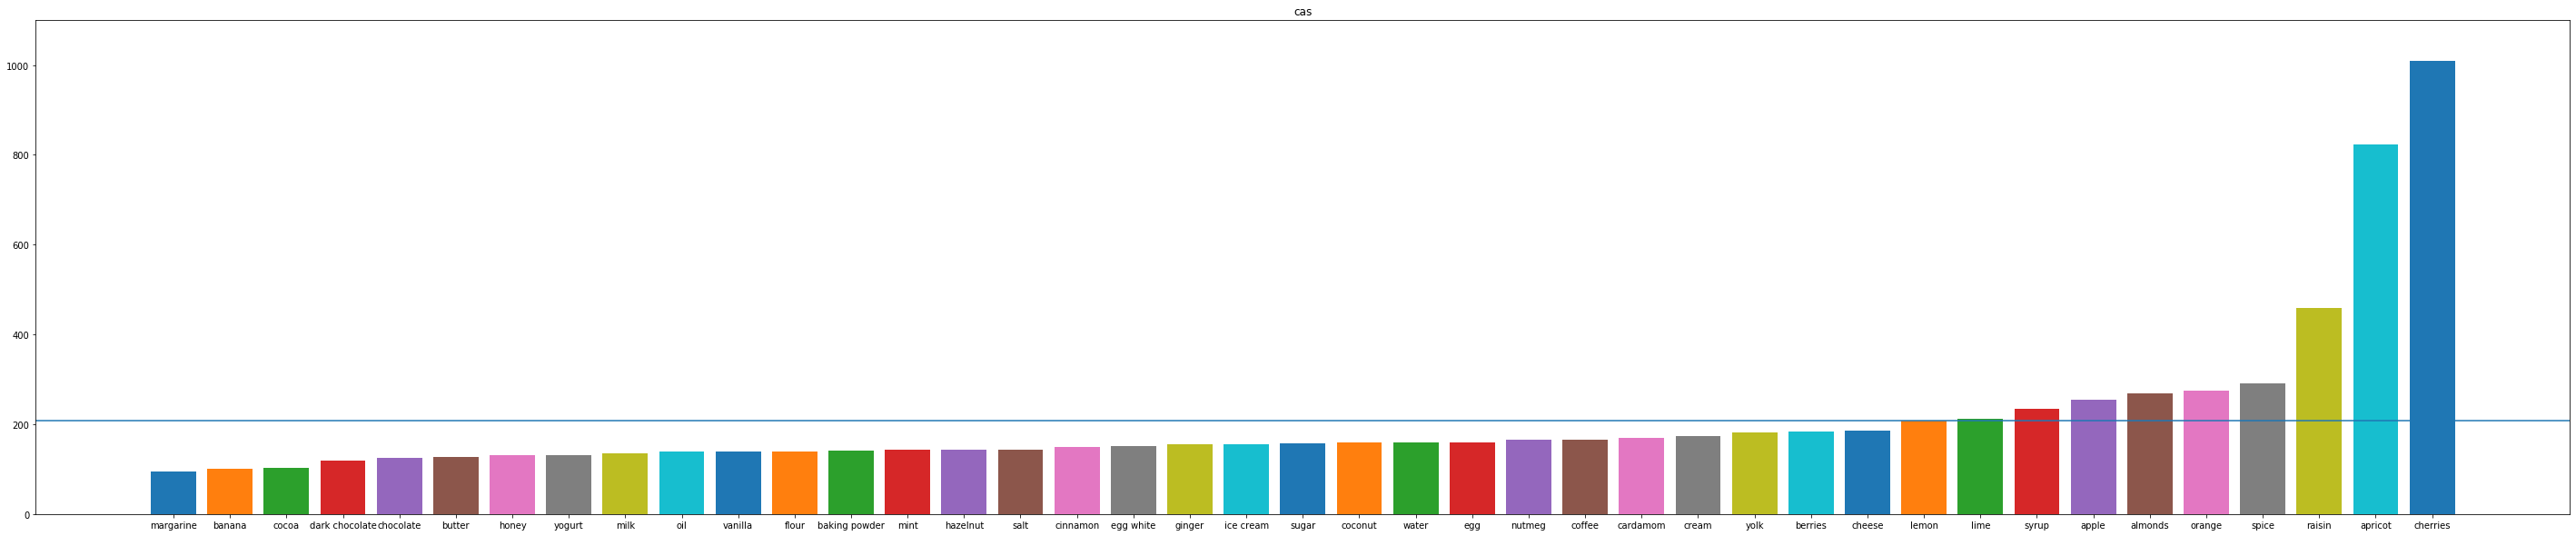

In [166]:
ar_time_by_ingredient = pd.DataFrame.from_dict(times, orient='index', columns=['time', 'count'])
ar_time_table = ar_time_by_ingredient[ar_time_by_ingredient['count'] >= 100].sort_values(by='time')  # odstranimo sestavine ki so malo zastopane
mean_time = ar_time_table.time.mean()

%matplotlib inline

fig = plt.figure(figsize=(50,10))
ax1 = fig.add_subplot(111)
ax1.set_title("cas")
ax1.set_ylim(0, 1100)
ax1.axhline(y=mean_time)
for ing, s in ar_time_table.iterrows():
    ax1.bar(ing, s.time)

Presenetljivo lahko vidimo, da je čas priprave sladic odvisen od določenih sestavin.

Ker se mi to zdi sumljivo bom poskusil odstraniti oba ekstremna časa (najdaljšega in najkrajšega).

In [167]:
times = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_time_converted = ar_recipes_with_ing.time.apply(to_minutes)
    ar_positive_times = ar_time_converted[ar_time_converted > 0]
    ar_removed_extreme_times = ar_positive_times.sort_values()[1:-1]  # odstranimo oba ekstrema
    ar_mean_time = ar_positive_times.mean()
    ar_recipe_count = len(ar_contains_ing) - 2
    times[ing] = [int(ar_mean_time), ar_recipe_count]  # round to whole minute

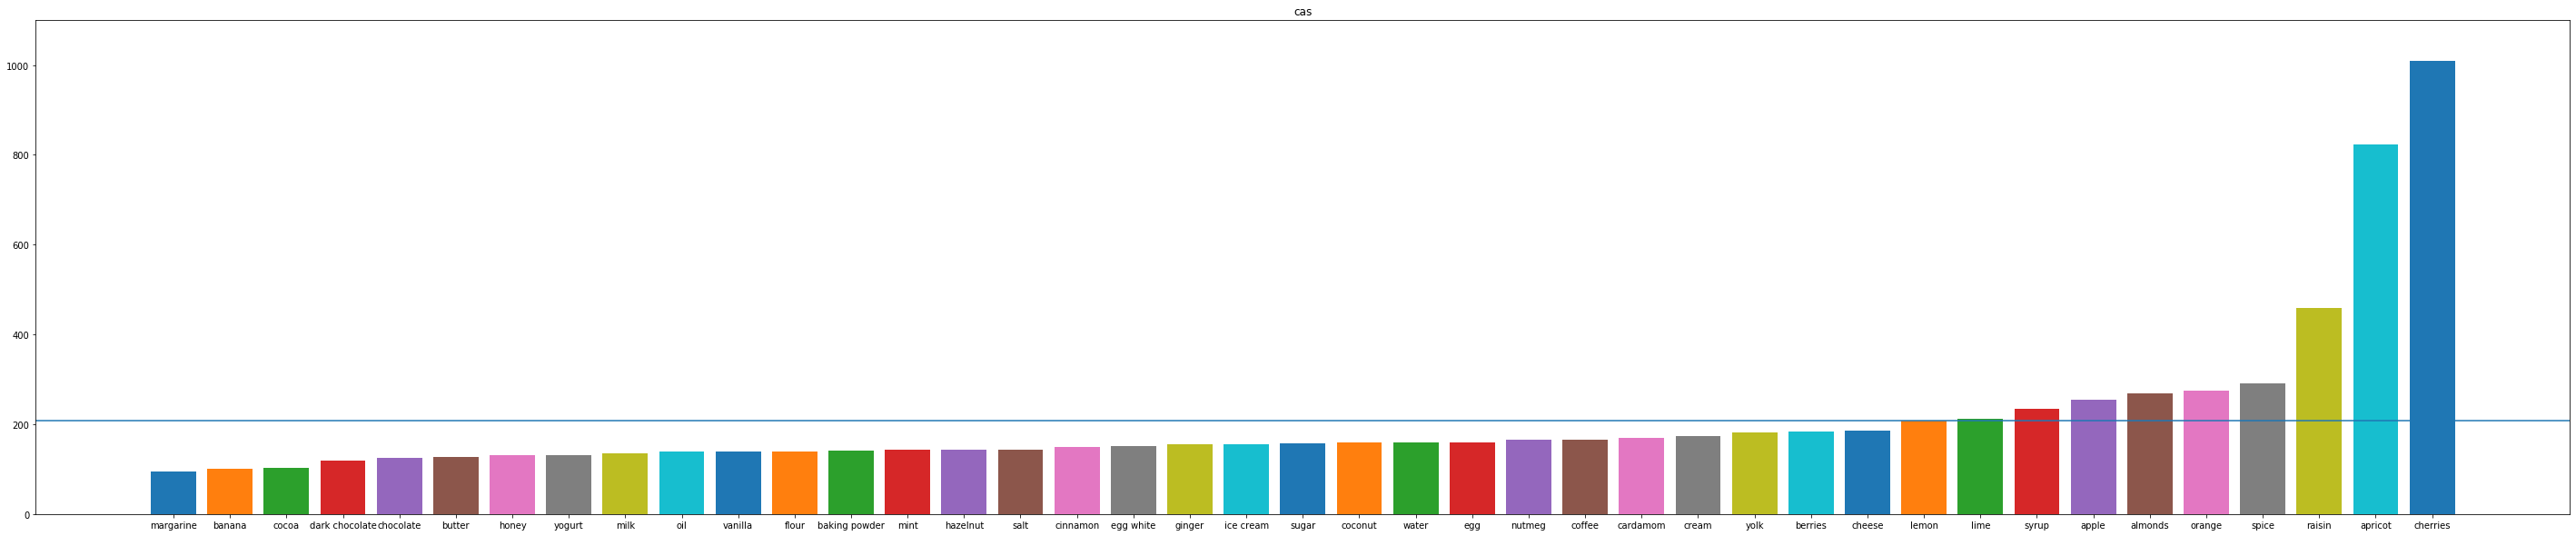

In [201]:
ar_time_by_ingredient = pd.DataFrame.from_dict(times, orient='index', columns=['time', 'count'])
ar_time_table = ar_time_by_ingredient[ar_time_by_ingredient['count'] >= 100].sort_values(by='time')  # odstranimo sestavine ki so malo zastopane
mean_time = ar_time_table.time.mean()

%matplotlib inline

fig = plt.figure(figsize=(50,10))
ax1 = fig.add_subplot(111)
ax1.set_title("cas")
ax1.set_ylim(0, 1100)
ax1.axhline(y=mean_time)
for ing, s in ar_time_table.iterrows():
    ax1.bar(ing, s.time)

Kot vidimo se graf ne spremeni veliko. Če bi znal kaj statistike bi si lahko pomagal s standardnim odklonom, vendar bo to za potrebe te naloge zadoščalo.

Poglejmo si še ocene receptov s čokolado v primerjavi z ostalimi sladicami.

In [195]:
from typing import Tuple
def to_rating(ts: str) -> Tuple[float, int]:
    def aux(ts: str) -> Tuple[float, int]:
        if ts == '{}':
            return (0, 0)
        rating = json.loads(ts)
        # print(rating)
        return [float(rating['value']), int(rating['count'])]

    return aux(ts.replace("\'", '\"'))

In [229]:
ratings = dict()
for ing in ingredient_list.ingredient:
    jo_contains_ing = jo_ingredients[jo_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    ar_contains_ing = ar_ingredients[ar_ingredients.ingredient.str.contains(ing)].groupby('recipe')
    # print(f'{ing}: {len(jo_contains_ing.count())}')
    ar_recipes_with_ing = ar_recipes.filter(items=list(ar_contains_ing.count().index), axis=0)
    ar_rating = pd.DataFrame.from_dict(dict(ar_recipes_with_ing.rating.apply(to_rating).items()), columns=['value', 'count'], orient='index')
    ar_good_ratings = ar_rating[ar_rating['count'] > 0]
    ar_mean_rating = ar_good_ratings.value.mean()
    ar_total_count = ar_good_ratings['count'].sum()
    ratings[ing] = [ar_mean_rating, ar_total_count]
# for e in ar_recipes_with_ing.rating:
#     print(to_rating(e))
# ratings

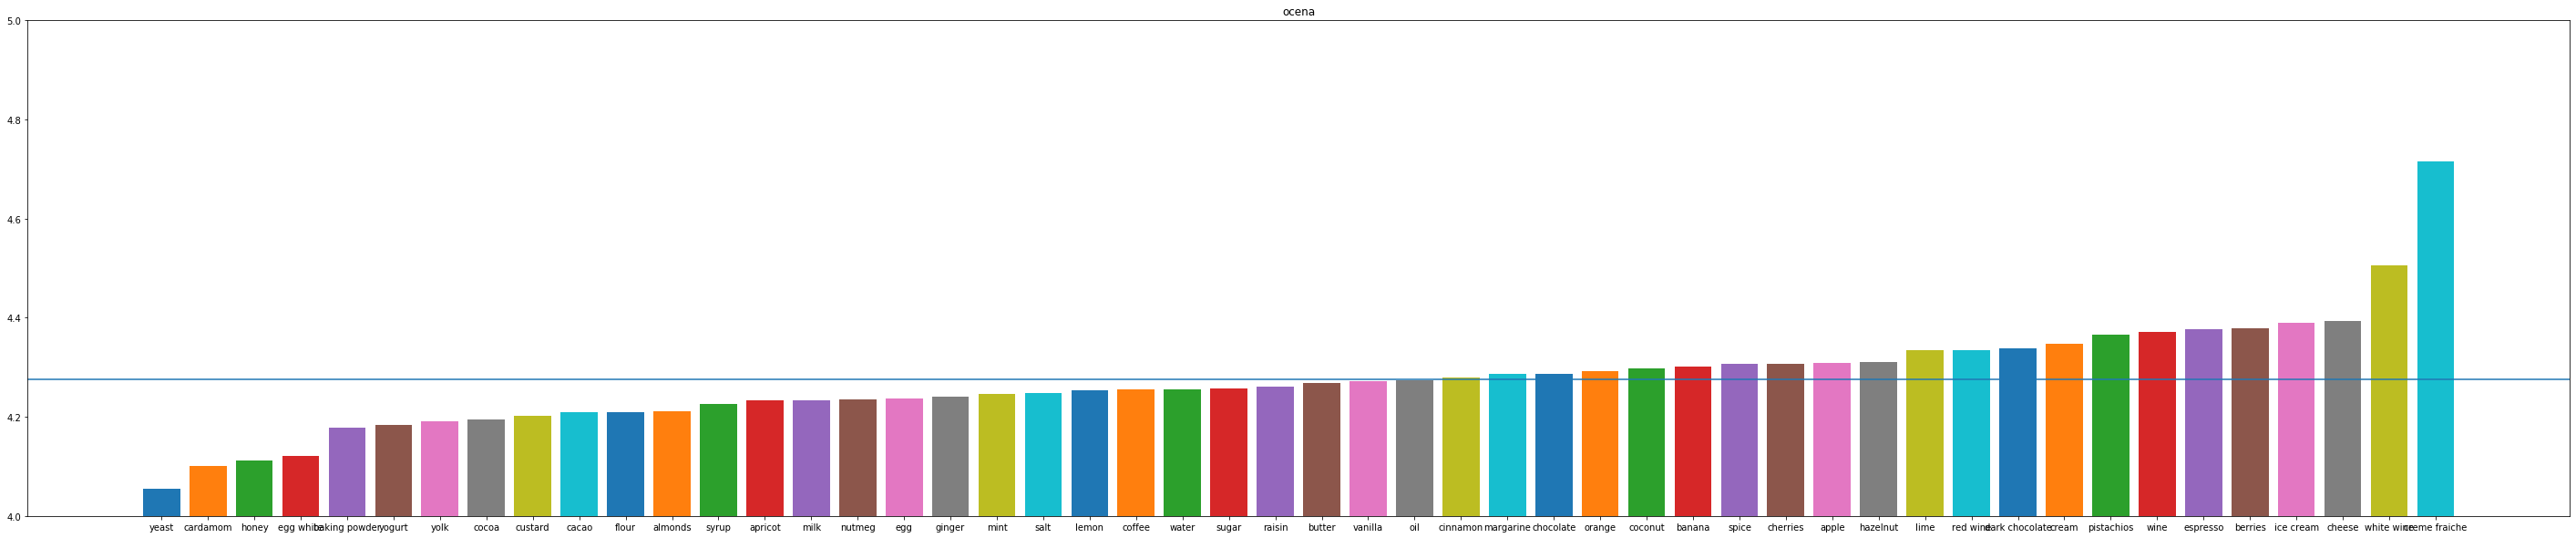

In [239]:
ar_rating_by_ingredient = pd.DataFrame.from_dict(ratings, orient='index', columns=['value', 'count'])
ar_rating_table = ar_rating_by_ingredient[ar_rating_by_ingredient['count'] >= 50].sort_values(by='value')  # odstranimo sestavine ki so malo zastopane
mean_rating = ar_rating_table.value.mean()

%matplotlib inline

fig = plt.figure(figsize=(50,10))
ax1 = fig.add_subplot(111)
ax1.set_title("ocena")
ax1.set_ylim(4, 5)
ax1.axhline(y=mean_rating)
for ing, s in ar_rating_table.iterrows():
    ax1.bar(ing, s.value)

Opazimo lahko, da je creme fraiche zelo priljubljena sestavina, kvasa pa ljudje načeloma ne marajo.

Čokolada zgleda ne vpliva precej na oceno sladice.

Temna čokolada ima malo višje povprečje.

Presenetljivo je med manj priljubljen.